[Original author](https://designwith.ml/assets/docs/Meetup_clustering_sample)  
  
Clustering meetup.com data! Using the location and group information to cluster the members into 6 clusters - but it is up to you to figure out what they mean!  

Data was on Kaggle.

In [23]:
#these are all of the libraries i'll be using - and I load the groups.csv data
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [24]:
import pandas as pd
import os

# Construct the file path
file_path = "D:\\ADC\\Machine Learning\\ubb-sociology-ml\\lecture5\\data\\groups.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Data Step
This step we're going to look at our dataframes and become familiar with what's in them.

In [25]:
#this is what the groups.csv looks like as a dataframe - it is about the groups
df.head()

group_id  category_id          category.name     category.shortname  \
0      6388           14       health/wellbeing       health-wellbeing   
1      6510            4  community/environment  community-environment   
2      8458           26           pets/animals           pets-animals   
3      8940           29         sci-fi/fantasy         sci-fi-fantasy   
4     10104           26           pets/animals           pets-animals   

   city_id      city country              created  \
0    10001  New York      US  2002-11-21 16:50:46   
1    10001  New York      US  2003-05-20 14:48:54   
2    10001  New York      US  2004-03-27 09:55:41   
3    10001  New York      US  2002-11-16 04:49:16   
4    10001  New York      US  2003-10-22 21:39:49   

                                         description  \
0  Those who practice or hold a strong interest i...   
1  The New York Alternative Energy Meetupis for t...   
2                                          not_found   
3  Welcome to the The New York City Anime Meetup ...   
4  We welcome those who support pits, even if you...   

              group_photo.base_url  ...  \
0  https://secure.meetupstatic.com  ...   
1  https://secure.meetupstatic.com  ...   
2  https://secure.meetupstatic.com  ...   
3  https://secure.meetupstatic.com  ...   
4  https://secure.meetupstatic.com  ...   

                          organizer.photo.photo_link  \
0  https://secure.meetupstatic.com/photos/member/...   
1  https://secure.meetupstatic.com/photos/member/...   
2  https://secure.meetupstatic.com/photos/member/...   
3  https://secure.meetupstatic.com/photos/member/...   
4  https://secure.meetupstatic.com/photos/member/...   

                          organizer.photo.thumb_link organizer.photo.type  \
0  https://secure.meetupstatic.com/photos/member/...               member   
1  https://secure.meetupstatic.com/photos/member/...               member   
2  https://secure.meetupstatic.com/photos/member/...               member   
3  https://secure.meetupstatic.com/photos/member/...               member   
4  https://secure.meetupstatic.com/photos/member/...               member   

  rating state    timezone                    urlname utc_offset  \
0   4.39    NY  US/Eastern     alternative-health-nyc     -14400   
1   4.31    NY  US/Eastern  alternative-energy-meetup     -14400   
2   4.84    NY  US/Eastern                    Animals     -14400   
3   4.46    NY  US/Eastern                  NYC-Anime     -14400   
4   4.09    NY  US/Eastern                NYC-Pitbull     -14400   

       visibility                            who  
0          public            Explorers of Health  
1          public        Clean Energy Supporters  
2          public                  Animal Voices  
3          public                     Anime Fans  
4  public_limited  NYC Pits & People, Dog Lovers  

[5 rows x 36 columns]

In [26]:
#this is the df about the members
file_path2 = "D:\\ADC\\Machine Learning\\ubb-sociology-ml\\lecture5\\data\\members.csv"
df2 = pd.read_csv(file_path2,encoding = "ISO-8859-1" , nrows=1600133) #  This encoding is commonly used for Western European languages and is a single-byte encoding that can represent a wide range of characters, including characters with accents and diacritics.

In [27]:
df2.shape

(1600133, 14)

In [28]:
df2.head()

member_id                                                bio      city  \
0          3                                          not_found  New York   
1          3                                          not_found  New York   
2          3  Hi, I'm Matt. I'm an entrepreneur who has star...  New York   
3          3  Hi, I'm Matt. I'm an entrepreneur who has star...  New York   
4          3  Hi, I'm Matt. I'm an entrepreneur who has star...  New York   

  country      hometown               joined    lat  \
0      us  New York, NY  2007-05-01 22:04:37  40.72   
1      us  New York, NY  2011-01-23 14:13:17  40.72   
2      us  New York, NY  2010-12-30 18:47:34  40.72   
3      us  New York, NY  2011-01-03 14:45:21  40.72   
4      us  New York, NY  2010-12-30 18:34:50  40.72   

                              link   lon  member_name state member_status  \
0  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   
1  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   
2  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   
3  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   
4  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   

               visited  group_id  
0  2009-09-18 18:32:23    490552  
1  2011-03-20 01:02:11   1474611  
2  2011-01-18 20:37:23   1490492  
3  2011-07-23 03:42:28   1515830  
4  2011-06-13 18:33:23   1574965

## Data Cleaning Phase
In this phase, we'll sample a % of the data, and then use "one hot" encoding to turn string features into numbers for our mathematical models.

In [29]:
# I am sampling to 5,000 random samples from the dataframe since it is just SOOO big! This will help my code run faster
df2_sample = df2.sample(n=5000)

In [30]:
#let's explore the df by member id and the first record number of each - what are the features we want to use?
# group a DataFrame (df2_sample) by the 'member_id' column and then select the first row within each group.
# This operation is often used to get the first entry or a representative entry for each unique member ID.
df2_sample.groupby(['member_id']).first()

bio           city  \
member_id                                                                     
18613                                              not_found       New York   
26219                                              not_found  San Francisco   
39430                                              not_found       New York   
55921                                              not_found        Chicago   
63510                                Work at Voltaic Systems       New York   
...                                                      ...            ...   
48343352                                           not_found       New York   
48362792                                           not_found        Chicago   
48396742   I'm a starter league student looking to meet m...        Chicago   
48506432                                           not_found       New York   
48538082                                           not_found       New York   

          country           hometown               joined    lat  \
member_id                                                          
18613          us  Kiev/Philadelphia  2016-10-03 03:32:24  40.74   
26219          us          not_found  2016-02-02 08:47:59  37.78   
39430          us          not_found  2015-09-22 20:38:12  40.75   
55921          us          not_found  2015-05-23 22:47:17  42.01   
63510          us          not_found  2014-02-11 16:35:33  40.75   
...           ...                ...                  ...    ...   
48343352       us          not_found  2013-05-24 20:28:45  40.75   
48362792       us          Woodridge  2017-02-17 06:24:12  41.85   
48396742       us          not_found  2014-06-24 03:47:35  41.90   
48506432       us           New York  2016-06-26 02:03:40  40.74   
48538082       us          not_found  2015-11-03 04:59:31  40.76   

                                             link     lon  \
member_id                                                   
18613         http://www.meetup.com/members/18613  -73.99   
26219         http://www.meetup.com/members/26219 -122.42   
39430         http://www.meetup.com/members/39430  -73.99   
55921         http://www.meetup.com/members/55921  -87.67   
63510         http://www.meetup.com/members/63510  -73.99   
...                                           ...     ...   
48343352   http://www.meetup.com/members/48343352  -73.99   
48362792   http://www.meetup.com/members/48362792  -87.67   
48396742   http://www.meetup.com/members/48396742  -87.67   
48506432   http://www.meetup.com/members/48506432  -74.00   
48538082   http://www.meetup.com/members/48538082  -73.99   

                   member_name state member_status              visited  \
member_id                                                                 
18613                   Igor S    NY        active  2016-10-28 03:24:44   
26219                 mbennett    CA        active  2016-07-28 00:15:36   
39430                    Indra    NY        active  2015-09-22 20:38:12   
55921            Bethany Crome    IL        active  2015-07-18 21:17:18   
63510             Jeff Crystal    NY        active  2014-05-16 12:59:54   
...                        ...   ...           ...                  ...   
48343352         Michael  Duda    NY        active  2017-10-11 21:08:18   
48362792   Christopher Simokat    IL        active  2017-02-17 06:24:12   
48396742      Alex Niemczewski    IL        active  2014-06-24 03:47:35   
48506432                  Sara    NY        active  2016-06-26 02:03:40   
48538082         matt lederman    NY        active  2016-01-12 04:37:59   

           group_id  
member_id            
18613      20531560  
26219       1998291  
39430       6197942  
55921      12125382  
63510       8422992  
...             ...  
48343352    2357601  
48362792   22404773  
48396742   11263152  
48506432   18006682  
48538082   18564750  

[4747 rows x 13 columns]

df2_sample['group_id']: This extracts the 'group_id' column from the DataFrame df2_sample.  
pd.get_dummies(...): This function converts categorical variable(s) into dummy/indicator variables. In this case, it's applied to the 'group_id' column.  
prefix='group_id': This parameter adds a prefix to the newly created dummy variable columns to indicate their association with the original 'group_id'.  
  
  The resulting df2_sample_dummies DataFrame will contain new binary columns (0 or 1) for each unique value in the 'group_id' column. Each row will have a 1 in the column corresponding to its 'group_id' and 0s in the other columns.

In [31]:
#One feature I want to use is the GROUP ID - one thing that we can do is "get dummies" or "one-hot encoding" to
#turn string variables into numbers! look at it below
df2_sample_dummies = pd.get_dummies(df2_sample['group_id'], prefix = 'group_id')

In [32]:
#this is what it looks like to have "dummies" or one-hot encoded variables!
df2_sample_dummies.head()

group_id_6388  group_id_6510  group_id_8940  group_id_12907  \
1565950          False          False          False           False   
198212           False          False          False           False   
1137104          False          False          False           False   
195834           False          False          False           False   
1123255          False          False          False           False   

         group_id_15324  group_id_17921  group_id_18843  group_id_22211  \
1565950           False           False           False           False   
198212            False           False           False           False   
1137104           False           False           False           False   
195834            False           False           False           False   
1123255           False           False           False           False   

         group_id_23713  group_id_24765  ...  group_id_26178231  \
1565950           False           False  ...              False   
198212            False           False  ...              False   
1137104           False           False  ...              False   
195834            False           False  ...              False   
1123255           False           False  ...              False   

         group_id_26178525  group_id_26234228  group_id_26236747  \
1565950              False              False              False   
198212               False              False              False   
1137104              False              False              False   
195834               False              False              False   
1123255              False              False              False   

         group_id_26246923  group_id_26277107  group_id_26290255  \
1565950              False              False              False   
198212               False              False              False   
1137104              False              False              False   
195834               False              False              False   
1123255              False              False              False   

         group_id_26292068  group_id_26320944  group_id_26361954  
1565950              False              False              False  
198212               False              False              False  
1137104              False              False              False  
195834               False              False              False  
1123255              False              False              False  

[5 rows x 2690 columns]

In [33]:
#Let's combine it back to our original dataframe
df2_sample_dummies_concat = pd.concat([df2_sample, df2_sample_dummies], axis=1)

In [34]:
df2_sample_dummies_concat.head()

member_id                                                bio  \
1565950   45784082           Mahi Inampudi, chief architect cars.com.   
198212     3913751  Hi, I'm Monica, I love art and am very excited...   
1137104   14429094                                          not_found   
195834     3893698                                          not_found   
1123255   14318682                                          not_found   

                  city country       hometown               joined    lat  \
1565950        Chicago      us      not_found  2012-04-26 12:00:59  41.88   
198212        New York      us      not_found  2008-05-25 23:12:10  40.75   
1137104       New York      us       New York  2017-09-21 21:44:27  40.76   
195834   San Francisco      us  San Francisco  2014-11-12 15:24:17  37.77   
1123255       New York      us       New York  2017-08-19 01:37:21  40.75   

                                           link     lon        member_name  \
1565950  http://www.meetup.com/members/45784082  -87.65      Mahi Inampudi   
198212    http://www.meetup.com/members/3913751  -73.97             Monica   
1137104  http://www.meetup.com/members/14429094  -73.99  Kirill Cherkashin   
195834    http://www.meetup.com/members/3893698 -122.40              Huang   
1123255  http://www.meetup.com/members/14318682  -73.99      Marina Klutse   

         ... group_id_26178231 group_id_26178525 group_id_26234228  \
1565950  ...             False             False             False   
198212   ...             False             False             False   
1137104  ...             False             False             False   
195834   ...             False             False             False   
1123255  ...             False             False             False   

         group_id_26236747  group_id_26246923  group_id_26277107  \
1565950              False              False              False   
198212               False              False              False   
1137104              False              False              False   
195834               False              False              False   
1123255              False              False              False   

         group_id_26290255  group_id_26292068  group_id_26320944  \
1565950              False              False              False   
198212               False              False              False   
1137104              False              False              False   
195834               False              False              False   
1123255              False              False              False   

         group_id_26361954  
1565950              False  
198212               False  
1137104              False  
195834               False  
1123255              False  

[5 rows x 2704 columns]

In [35]:
#let's repeat the same process for the "cities" feature
df2_sample_dummies_cities = pd.get_dummies(df2_sample_dummies_concat['city'], prefix = 'cities_')
df2_sample_dummies_concat_cities2 = pd.concat([df2_sample_dummies_concat, df2_sample_dummies_cities], axis=1)

In [36]:
df2_sample_dummies_concat_cities2.head()

member_id                                                bio  \
1565950   45784082           Mahi Inampudi, chief architect cars.com.   
198212     3913751  Hi, I'm Monica, I love art and am very excited...   
1137104   14429094                                          not_found   
195834     3893698                                          not_found   
1123255   14318682                                          not_found   

                  city country       hometown               joined    lat  \
1565950        Chicago      us      not_found  2012-04-26 12:00:59  41.88   
198212        New York      us      not_found  2008-05-25 23:12:10  40.75   
1137104       New York      us       New York  2017-09-21 21:44:27  40.76   
195834   San Francisco      us  San Francisco  2014-11-12 15:24:17  37.77   
1123255       New York      us       New York  2017-08-19 01:37:21  40.75   

                                           link     lon        member_name  \
1565950  http://www.meetup.com/members/45784082  -87.65      Mahi Inampudi   
198212    http://www.meetup.com/members/3913751  -73.97             Monica   
1137104  http://www.meetup.com/members/14429094  -73.99  Kirill Cherkashin   
195834    http://www.meetup.com/members/3893698 -122.40              Huang   
1123255  http://www.meetup.com/members/14318682  -73.99      Marina Klutse   

         ... group_id_26290255 group_id_26292068 group_id_26320944  \
1565950  ...             False             False             False   
198212   ...             False             False             False   
1137104  ...             False             False             False   
195834   ...             False             False             False   
1123255  ...             False             False             False   

         group_id_26361954  cities__Chicago  cities__Chicago Ridge  \
1565950              False             True                  False   
198212               False            False                  False   
1137104              False            False                  False   
195834               False            False                  False   
1123255              False            False                  False   

         cities__New York  cities__San Francisco  cities__South San Francisco  \
1565950             False                  False                        False   
198212               True                  False                        False   
1137104              True                  False                        False   
195834              False                   True                        False   
1123255              True                  False                        False   

         cities__West New York  
1565950                  False  
198212                   False  
1137104                  False  
195834                   False  
1123255                  False  

[5 rows x 2710 columns]

In [37]:
#write it to a CSV before your kernel dies! this could be helpful if you want to use the same sample again in the future
df2_sample_dummies_concat_cities2.to_csv('members2.csv')

In [38]:
!cp members2.csv "gdrive/My Drive/Work/UBB 2023/02_Cursuri/Session #5/data/"

'cp' is not recognized as an internal or external command,
operable program or batch file.


## Training the model
We will use groupIDs and Cities as our main features to train the model - and since we want the data itself to group and tell us what the major groups are - we are going to use a technique called "clustering" (or k-means clustering, where k= the number of clusters). I don't know in advance what the best number of clusters will be, so I will try a bunch of different k (k= 2,4,6,8) and then see how well our clusters are performing. See below :)

In [39]:
df2_sample_dummies_concat_cities2_train = df2_sample_dummies_concat_cities2.loc[:, 'group_id_6388':'cities__West New York']
df2_sample_dummies_concat_cities2_train.head()

group_id_6388  group_id_6510  group_id_8940  group_id_12907  \
1565950          False          False          False           False   
198212           False          False          False           False   
1137104          False          False          False           False   
195834           False          False          False           False   
1123255          False          False          False           False   

         group_id_15324  group_id_17921  group_id_18843  group_id_22211  \
1565950           False           False           False           False   
198212            False           False           False           False   
1137104           False           False           False           False   
195834            False           False           False           False   
1123255           False           False           False           False   

         group_id_23713  group_id_24765  ...  group_id_26290255  \
1565950           False           False  ...              False   
198212            False           False  ...              False   
1137104           False           False  ...              False   
195834            False           False  ...              False   
1123255           False           False  ...              False   

         group_id_26292068  group_id_26320944  group_id_26361954  \
1565950              False              False              False   
198212               False              False              False   
1137104              False              False              False   
195834               False              False              False   
1123255              False              False              False   

         cities__Chicago  cities__Chicago Ridge  cities__New York  \
1565950             True                  False             False   
198212             False                  False              True   
1137104            False                  False              True   
195834             False                  False             False   
1123255            False                  False              True   

         cities__San Francisco  cities__South San Francisco  \
1565950                  False                        False   
198212                   False                        False   
1137104                  False                        False   
195834                    True                        False   
1123255                  False                        False   

         cities__West New York  
1565950                  False  
198212                   False  
1137104                  False  
195834                   False  
1123255                  False  

[5 rows x 2696 columns]

In [40]:
#k = 8 training model
km = KMeans(n_clusters=8)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k8 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

CPU times: total: 1.06 s
Wall time: 517 ms
CPU times: total: 2.36 s
Wall time: 371 ms


In [41]:
#k=6 training model
km = KMeans(n_clusters=6)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k6 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

CPU times: total: 1.12 s
Wall time: 377 ms
CPU times: total: 2.14 s
Wall time: 353 ms


In [42]:
# k = 4 training model
km = KMeans(n_clusters=4)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k4 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

CPU times: total: 875 ms
Wall time: 399 ms
CPU times: total: 2.59 s
Wall time: 472 ms


In [43]:
# k = 2 training model
km = KMeans(n_clusters=2)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k2 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

CPU times: total: 1.05 s
Wall time: 450 ms
CPU times: total: 2.3 s
Wall time: 375 ms


## Model Evaluation


In [44]:
silhouette = [silhouette_k2, silhouette_k4, silhouette_k6, silhouette_k8]
count_k = [2, 4, 6, 8]

count_silhouette = list(zip(count_k, silhouette))
print(count_silhouette)

[(2, np.float64(0.1868771126594202)), (4, np.float64(0.12592010318979363)), (6, np.float64(0.12925768306193183)), (8, np.float64(0.0533497769564621))]


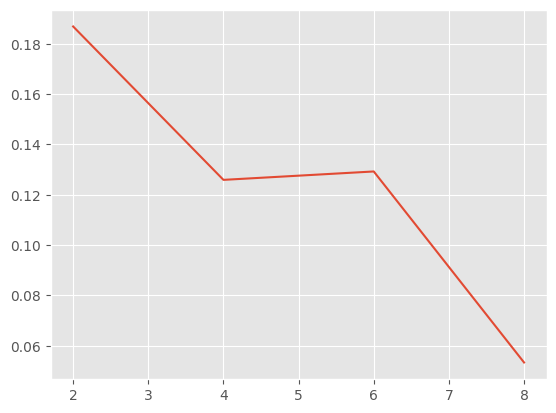

In [45]:
plt.plot(*zip(*count_silhouette))

* No Clear Elbow:
If the inertia plot doesn't show a clear elbow and the inertia decreases smoothly without a significant break point, it might be challenging to determine the optimal k based solely on this method.  
  
* Slight Elbow:
If there's a slight elbow, it suggests that adding more clusters beyond that point provides diminishing returns in terms of explaining the variance in the data.  
  
* Sharp Elbow:
If there's a sharp elbow, it indicates a more pronounced point where the addition of clusters is less beneficial. This is often considered a good candidate for the optimal number of clusters.  

  However, it's important to note that the elbow method has limitations, and the choice of k may not always be entirely clear-cut. It's often used as a heuristic rather than a strict rule. Other factors, such as domain knowledge, the context of the problem, and the specific characteristics of the data, should also be considered.

## Model Output
Now that we've decided on k=4 clusters, let's assign the cluster labels back to the original data, and make it interpretable!

In [46]:
km = KMeans(n_clusters=4)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters4 = km.labels_.tolist()
silhouette_k4 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:50000], clusters[0:50000])

CPU times: total: 1.23 s
Wall time: 423 ms


In [47]:
df2_sample_dummies_concat_cities2_train.loc[:, "cluster_number"] = clusters4

In [48]:
df2_sample_dummies_concat_cities2_train.head()

group_id_6388  group_id_6510  group_id_8940  group_id_12907  \
1565950          False          False          False           False   
198212           False          False          False           False   
1137104          False          False          False           False   
195834           False          False          False           False   
1123255          False          False          False           False   

         group_id_15324  group_id_17921  group_id_18843  group_id_22211  \
1565950           False           False           False           False   
198212            False           False           False           False   
1137104           False           False           False           False   
195834            False           False           False           False   
1123255           False           False           False           False   

         group_id_23713  group_id_24765  ...  group_id_26292068  \
1565950           False           False  ...              False   
198212            False           False  ...              False   
1137104           False           False  ...              False   
195834            False           False  ...              False   
1123255           False           False  ...              False   

         group_id_26320944  group_id_26361954  cities__Chicago  \
1565950              False              False             True   
198212               False              False            False   
1137104              False              False            False   
195834               False              False            False   
1123255              False              False            False   

         cities__Chicago Ridge  cities__New York  cities__San Francisco  \
1565950                  False             False                  False   
198212                   False              True                  False   
1137104                  False              True                  False   
195834                   False             False                   True   
1123255                  False              True                  False   

         cities__South San Francisco  cities__West New York  cluster_number  
1565950                        False                  False               3  
198212                         False                  False               1  
1137104                        False                  False               1  
195834                         False                  False               0  
1123255                        False                  False               1  

[5 rows x 2697 columns]

In [49]:
df2_sample_dummies_concat_cities2_train["cluster_number"].value_counts()

cluster_number
1    2841
0    1329
3     829
2       1
Name: count, dtype: int64

## Tadah! We have a merged dataframe of members, clustered by their city and groups they're interested in, merged on what the group categories are (from the original groups df) and we can now export this and explore!

In [50]:
df2_sample.head()

member_id                                                bio  \
1565950   45784082           Mahi Inampudi, chief architect cars.com.   
198212     3913751  Hi, I'm Monica, I love art and am very excited...   
1137104   14429094                                          not_found   
195834     3893698                                          not_found   
1123255   14318682                                          not_found   

                  city country       hometown               joined    lat  \
1565950        Chicago      us      not_found  2012-04-26 12:00:59  41.88   
198212        New York      us      not_found  2008-05-25 23:12:10  40.75   
1137104       New York      us       New York  2017-09-21 21:44:27  40.76   
195834   San Francisco      us  San Francisco  2014-11-12 15:24:17  37.77   
1123255       New York      us       New York  2017-08-19 01:37:21  40.75   

                                           link     lon        member_name  \
1565950  http://www.meetup.com/members/45784082  -87.65      Mahi Inampudi   
198212    http://www.meetup.com/members/3913751  -73.97             Monica   
1137104  http://www.meetup.com/members/14429094  -73.99  Kirill Cherkashin   
195834    http://www.meetup.com/members/3893698 -122.40              Huang   
1123255  http://www.meetup.com/members/14318682  -73.99      Marina Klutse   

        state member_status              visited  group_id  
1565950    IL        active  2012-04-26 12:00:59   1985191  
198212     NY        active  2012-02-14 03:52:59    687322  
1137104    NY        active  2017-10-18 19:43:19  24692400  
195834     CA        active  2015-10-03 01:15:36   3153782  
1123255    NY        active  2017-08-20 23:45:04   5118552

In [51]:
df2_sample.loc[:, "clusters_number"] = clusters4

In [52]:
df2_sample.to_csv('members_cluster_group.csv')

In [53]:
!cp members_cluster_group.csv "gdrive/My Drive/Work/UBB 2023/02_Cursuri/Session #5/data/"

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [54]:
df2_sample.head()

member_id                                                bio  \
1565950   45784082           Mahi Inampudi, chief architect cars.com.   
198212     3913751  Hi, I'm Monica, I love art and am very excited...   
1137104   14429094                                          not_found   
195834     3893698                                          not_found   
1123255   14318682                                          not_found   

                  city country       hometown               joined    lat  \
1565950        Chicago      us      not_found  2012-04-26 12:00:59  41.88   
198212        New York      us      not_found  2008-05-25 23:12:10  40.75   
1137104       New York      us       New York  2017-09-21 21:44:27  40.76   
195834   San Francisco      us  San Francisco  2014-11-12 15:24:17  37.77   
1123255       New York      us       New York  2017-08-19 01:37:21  40.75   

                                           link     lon        member_name  \
1565950  http://www.meetup.com/members/45784082  -87.65      Mahi Inampudi   
198212    http://www.meetup.com/members/3913751  -73.97             Monica   
1137104  http://www.meetup.com/members/14429094  -73.99  Kirill Cherkashin   
195834    http://www.meetup.com/members/3893698 -122.40              Huang   
1123255  http://www.meetup.com/members/14318682  -73.99      Marina Klutse   

        state member_status              visited  group_id  clusters_number  
1565950    IL        active  2012-04-26 12:00:59   1985191                3  
198212     NY        active  2012-02-14 03:52:59    687322                1  
1137104    NY        active  2017-10-18 19:43:19  24692400                1  
195834     CA        active  2015-10-03 01:15:36   3153782                0  
1123255    NY        active  2017-08-20 23:45:04   5118552                1

In [55]:
df2_sample['city'].nunique()

6

In [56]:
df2_sample['group_id'].nunique()

2690